<a href="https://colab.research.google.com/github/Jaacunamatata/git-started/blob/jose/Inverted_pendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulation of an inverted Pendulum.
This is a fork of the work of Vicente Jimenez (http://r6500.blogspot.com/)

# System model

This document describes the control of an inverted pendulum

![Inverted pendulum](https://raw.githubusercontent.com/R6500/Python-bits/master/Colaboratory/Artwork/Inverted%20Pendulum.png)

We have a pendulum that we want to keep vertical (at angle zero). The pendulum generates a load torque **TL** that can be calculated:

$$T_{L}=m \cdot g \cdot l \cdot sin(\theta)$$

We will use a motor to generate a torque **Tm**, that aims to keep the pendulum straight

## Load Python modules

We will start giving some values to the pendulum properties.

**Execute** the following code block to load the needed Python modules.

In [ ]:
# The code is designed to work with Python 3.x
# To provide Python 2.7 compatibility, we can use two imports:
from __future__ import print_function
from __future__ import division

# Set to True if we are in colaboratory of False elsewere
colaboratory = True

if colaboratory:
    # We also load the calc module
    !rm calc.*
    !wget https://raw.githubusercontent.com/R6500/Python-bits/master/Modules/calc.py

# We import numpy and calc
import numpy as np
import calc

# Erase output after import
from IPython.display import clear_output
clear_output()

# Check loaded modules
try:
    print('calc version: ',calc.version)
except:
    print('Error loading the calc module')

calc version:  2/7/2018B


## Pendulum parameters

Now we can give the pendulum some parameters and calculate the torque **TL** as function of the angle.

**Execute** the following code block.

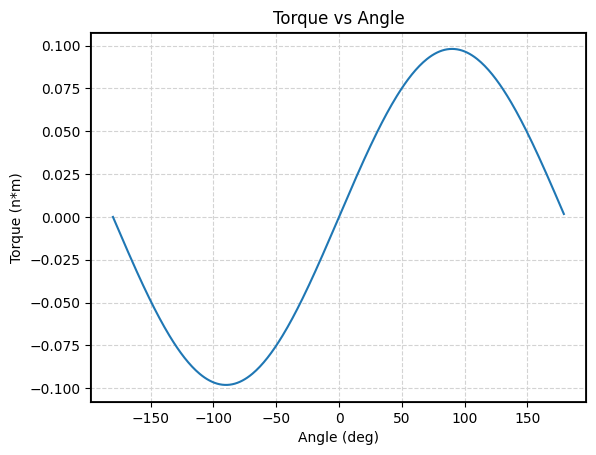

In [ ]:
# Data for the pendulum

m = 0.1   # [kg]   Mass
l = 0.1   # [m]    Length
g = 9.81  # [s^-2] Gravity acceleration

# Torque vs angle graph

vAngle = np.arange(-180.0,180.0,1.0)
vTl    = m*g*l*np.sin(np.deg2rad(vAngle))

# Indicate the calc module that we operate inside colaboratory
# This is needed to give more pleasant graphipcs
calc.setColaboratory(colaboratory)

# Torque graph
calc.plot11(vAngle,vTl,"Torque vs Angle","Angle (deg)","Torque (n*m)")


## Motor parameters

Now we can define a motor to be used with the pendulum.

For this document we will define a motor that has a maximum torque bigger than the maximum torque the pendulum can generate.

We will also consider that the only inertial momentum of the motor is the one of the pendulum

>$J=m \cdot l^2$

**Execute** the following code block to generate the motor data.

In [ ]:
# Motor data

# We will calculate the motor parameters from typical motor information
# We will only consider the intertial momentum of the pendulum

dcVoltage    = 12     # [V]
stallCurrent = 85     # [A]
stallTorque  = 0.5    # [N*m]
unloadedRPM  = 19300  # [min^-1]

# Calculations of constants of the motor

# Convert unloaded speed from RPM to rad/s
unloadedSpeed = 2.0*np.pi*unloadedRPM/60.0

# Calculate the winding resistance from the stall current
R = dcVoltage/stallCurrent

# Calculate the motor constant
k = stallTorque/stallCurrent

# Inertial momentum
J = m*l*l

# Show the results
calc.printVar("R",R,"Ohms")
calc.printVar("k",k,"N*m / A")
calc.printVar("J",J,"kg*m^2",sci=False)

R = 141.176 mOhms
k = 5.882 mN*m / A
J = 0.0010 kg*m^2


## Open loop

We can try to operate the pendulum in open loop




We can solve the dynamics in open loop by calculating the torque on the pendulum at each time step

>$T=m \cdot g \cdot l \cdot sin(\theta)+\frac{k}{R}(-V-k\cdot \omega)-\mu\cdot\omega$

We have added a friction term (the last one in the above expression) to be a little more realistic on a practical case. It also helps to damp a little the operation of the system.

**Execute** the following code block to simulate the system in open loop.

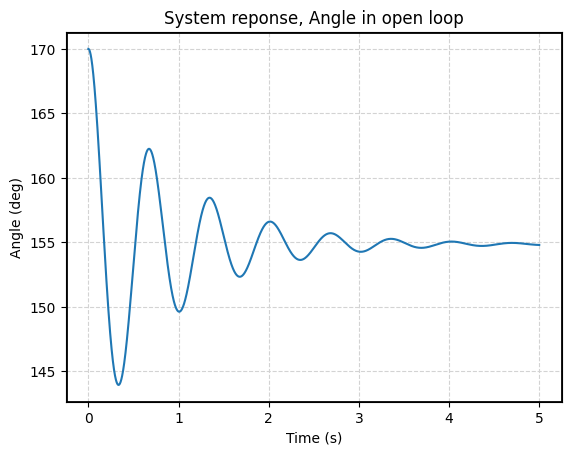

In [ ]:


# System dynamics

# We will consider a friction value to damp the system
mu = 2e-3 # [N*m*s]

# Time information
tEnd  = 5.0 #[s]
tStep = 0.001 #[s]
vTime = np.arange(0.0,tEnd,tStep)

# Start condition
startAngle = 170




# In open loop we command/send a voltage to the motor, this is the equivalent to "setpoint"
# Define the motor voltage
V = 1.0 #[V]
# Stall motor torque
Tm = V*k/R
vTm=Tm*np.ones(len(vAngle))



# State variables
angle = np.deg2rad(startAngle) #rad
speed = 0 #rad/s

# Output vectors
vSpeed  = []
vAngle  = []
vTorque = []

# Do the simulation
# We solve using the Euler method because is easier to
# understand and we only need qualitative results
for time in vTime:
    # Calculate torque
    T = m*g*l*np.sin(angle)+(k/R)*(-V-k*speed)-mu*speed
    # Calculate acceleration, speed and angle
    alpha = T/J
    speedNew = speed + alpha*tStep
    angleNew = angle + speed*tStep
    # Update output data
    vTorque.append(T)
    vSpeed.append(speed)
    vAngle.append(angle)
    # Udate state information
    speed = speedNew
    angle = angleNew

# Show angle graph
calc.plot11(vTime,np.rad2deg(vAngle),"System reponse, Angle in open loop"
            ,"Time (s)","Angle (deg)")


## PID Closed loop operation

Using open loop operation we cannot reach the upward position on the inverted pendulum. Moreover, we have little controlon the dynamics of the system.

The best control of the pendulum requires using a controller that generates the motor drive voltage as function of the state of the system.

There are several option for the control system. One of them is using a PID controller.

![PID controller](https://raw.githubusercontent.com/R6500/Python-bits/master/Colaboratory/Artwork/PID%20Motor.png)

In a PID contoller we compare the system output with a goal **G** value and calculate the error between the state and the goal. As, in our case we want to control the angle, the error will be:

>$\varepsilon=\theta-\theta_{G}$

Then we generate the input of the system by negative feedback using three elements:

1) Value proportional to the error

2) Value proportions to the time integral of the error

3) Value proportional to the time derivative of the error

So, in our case:

>$V=-P \cdot \varepsilon -I \cdot \int \varepsilon dt -D \cdot \frac{d\varepsilon}{dt}$

The following code simulates the inverted pendulum and the motor dynamics under PID control.

You can play changing the goal and the P, I and D values and **executing** the code.


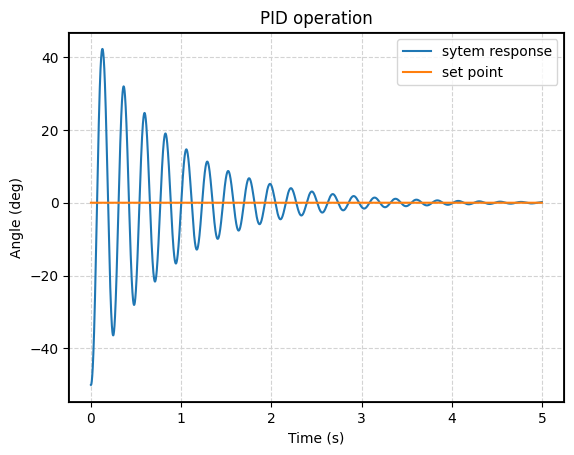

In [ ]:
# Closed loop operation

# This time we will solve the dynamics using Runge-Kutta
# That gives a much more exact solution depending on the
# P, I and D settings of the controller

# Some interesting cases
# P =  5, I =   0, D =  0 Proportional only (Error depends on goal angle)
# P = 20, I =   0, D =  0 Less error but more oscillations
# P =  5, I = 0.5, D =  0 Less error than P=5 only



# SET POINT, we want the pendulum to be in a straight position (perpendicular to the floor)-> tetha=0 deg
angleGoal = 0.0

##########################
## TODO: change constants

# Proportional constant
P = 20

# Integral constant
I = 0.0

# Derivative constant
D = 0.0
##END_TODO
########################




# We will consider a friction value to damp the system
mu = 2e-3 # [N*m*s]

# Time information
tEnd  = 5.0 #[s]
tStep = 0.001 #[s]
vTime = np.arange(0.0,tEnd,tStep)

# Start condition
startAngle = -50

# State variables [speed,angle]
x = [0.0,np.deg2rad(startAngle)]

# Output vector
vAngle  = []

# Angle goal in rad
goal = np.deg2rad(angleGoal)

# Initialize integral
integ = 0.0

# Initialize derivative
prevError = 0

# Derivative of the state variables (for Runge-Kutta)
def fderClose(x,t):
    global integ,prevError
    error = x[1]-goal

    # Calculate integral term
    integ = integ + error*tStep

    # Calculate voltage
    V = -(P*error+I*integ+D*(error-prevError)/tStep)
    if V > dcVoltage:
       V = dcVoltage
    if V < -dcVoltage:
       V = -dcVoltage

    prevError = error

    # Calculate torque
    T = m*g*l*np.sin(x[1])+(k/R)*(V-k*x[0])-mu*x[0]
    # Calculate acceleration
    alpha = T/J
    # Return state derivatives
    # [0] d speed / dt = alpha
    # [1] d angle / dt = speed
    return np.array([alpha,x[0]])

# Do the simulation using Runge-Kutta (4th order)
for time in vTime:
    # Store data
    vAngle.append(x[1])

    # Update state using Runge-Kutta
    x = calc.rk4(x,time,fderClose,tStep)

# Goal value
vGoal = angleGoal*np.ones(len(vTime))

# Show graphs
calc.plot1n(vTime,[np.rad2deg(vAngle),vGoal]
             ,"PID operation"
             ,"Time (s)","Angle (deg)",labels=["sytem response","set point"])
